In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import pandas as pd
import datatable as dt
import time
from collections import Counter

random.seed(42)
np.random.seed(42)
SEED = 42
BATCH_SIZE = 1024

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
# 节约内存的一个标配函数
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df

In [3]:
def confusion_matrix(label, predict, n):
    """
    计算混淆矩阵
    :param label: 标签，np.array类型。形状可以是(n_sample,) 或者 (n_sample, n_classes)，当为第二种形状时可以表示多标签分类的情况
    :param predict: 预测值，与 `label` 同理
    :param n: 类别数目
    :return: 混淆矩阵，np.array类型。shape 为 (n, n)。$cm_{ij}$表示真实标签为 $i$，预测标签为 $j$ 的样本个数
    """
    k = (label >= 0) & (label < n)
    # bincount()函数用于统计数组内每个非负整数的个数
    # 详见 https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html
    return np.bincount(n * label[k].astype(int) + predict[k], minlength=n ** 2).reshape(n, n)


def auc(y, p, classes):
    """
    给定真实标签和预测标签，计算每个类别的auc值。实际只算出了roc曲线上一个点，即一个(fpr, tpr)，再并上(0, 0)和(1, 1)来计算auc
    :param y: 标签，np.array类型
    :param p: 预测标签，np.array类型
    :param classes: 类别，list-like，表示有哪些类别
    """
    p = p.cpu()
    all_aucs = np.zeros(len(classes))
    for i, c in enumerate(classes):
        _y = np.zeros_like(y)
        _y[y==c] = 1
        _y[y!=c] = 0
        _p = np.zeros_like(p)
        _p[p==c] = 1
        _p[p!=c] = 0
#         print(_y, _p)
        cm = confusion_matrix(_y, _p, 2)
#         print(cm)
        tpr = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) if (cm[0, 0] + cm[0, 1]) != 0 else 0
        fpr = (cm[1, 0] / (cm[1, 0] + cm[1, 1])) if (cm[1, 0] + cm[1, 1]) != 0 else 0
        tpr = [0, tpr, 1]
        fpr = [0, fpr, 1]
        auc = metrics.auc(fpr, tpr)
        all_aucs[i] = auc
        if _y.sum() == 0 or _p.sum() == 0:
            all_aucs[i] = 0
    return all_aucs

In [4]:
y = np.random.randint(0, 10, 100)
p = np.random.randint(0, 10, 100)

classes = list(range(10))
weights = np.arange(0, 1, 0.1)
all_aucs = auc(y, p, classes)

weighted_auc = (all_aucs * weights).sum()
print(f"{all_aucs}\n{weighted_auc}")

classes = list(range(2))
y = np.array([0, 0, 1, 1])
p = np.array([0, 1, 0, 1])
all_aucs = auc(y, p, classes)

print(f"{all_aucs}")

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

# 导入数据集

## 处理训练数据
可在此做一些预处理：
- 从用户历史行为数据中筛掉在视频特征中没出现过的video_id
- 删除多余的列
- 调整列的顺序
- 改变列的数据类型


- 加载训练数据

In [7]:
df_train = reduce_mem(dt.fread("../完整版df_train.jay").to_pandas())

-- Mem. usage decreased to 1928.41 Mb (65.5% reduction),time spend:0.44 min


In [8]:
df_train = df_train[df_train['is_watch'] == 1]

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7353024 entries, 0 to 7353023
Columns: 130 entries, watch_label to da_4
dtypes: float16(97), float32(6), int16(6), int32(1), int8(20)
memory usage: 1.8 GB


In [9]:
# 删除 video_name、is_watch、video_id、user_id 列
df_train.drop(['video_name','is_watch','date', 'user_id', 'video_id'], axis=1, inplace=True)

In [11]:
df_train.columns

Index(['watch_label', 'is_share', 'is_work_day', 'u_avg_watch_label_1',
       'u_sum_watch_times_1', 'u_sum_watch_overs_1', 'u_sum_quit_times_1',
       'u_sum_skip_times_1', 'u_sum_comment_times_1', 'u_sum_collect_times_1',
       ...
       'class_5', 'class_6', 'class_7', 'class_8', 'class_9', 'da_0', 'da_1',
       'da_2', 'da_3', 'da_4'],
      dtype='object', length=130)

In [12]:
dataset = df_train
dataset.shape

(7353024, 130)

In [13]:
# 准备数据
watch_label = dataset.pop('watch_label').astype(np.uint8)
is_share = dataset.pop('is_share').astype(np.uint8)
watch_label.shape, is_share.shape, dataset.shape

((7353024,), (7353024,), (7353024, 128))

In [14]:
df_train.head()

,is_work_day,u_avg_watch_label_1,u_sum_watch_times_1,u_sum_watch_overs_1,u_sum_quit_times_1,u_sum_skip_times_1,u_sum_comment_times_1,u_sum_collect_times_1,u_sum_share_times_1,u_sum_watch_time_1,...,class_5,class_6,class_7,class_8,class_9,da_0,da_1,da_2,da_3,da_4
0,1,0.0,0,0,0,0,0,0,0,0.0,...,0.034393,0.034393,0.034393,0.233032,0.213745,0.174927,0.068787,0.248169,0.439453,0.068787
1,1,0.0,0,0,0,0,0,0,0,0.0,...,0.041534,0.041534,0.041534,0.625977,0.041534,0.346680,0.083069,0.083069,0.404053,0.083069
2,1,0.0,0,0,0,0,0,0,0,0.0,...,0.038147,0.038147,0.038147,0.038147,0.038147,0.076355,0.076355,0.694336,0.076416,0.076294
3,1,0.0,0,0,0,0,0,0,0,0.0,...,0.043579,0.043579,0.043579,0.043579,0.043579,0.087341,0.087341,0.650879,0.087341,0.087158
4,1,0.0,0,0,0,0,0,0,0,0.0,...,0.041779,0.350098,0.041779,0.041779,0.041779,0.324951,0.083557,0.083557,0.083557,0.424316


## 处理测试数据

- 加载测试数据

In [48]:
# 拼接好的测试数据集
df_test = reduce_mem(dt.fread("../完整版df_test.jay").to_pandas())

-- Mem. usage decreased to 820.89 Mb (65.7% reduction),time spend:0.20 min


In [49]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822180 entries, 0 to 2822179
Columns: 132 entries, user_id to da_4
dtypes: float16(120), float32(3), int32(3), int8(1), object(5)
memory usage: 820.9+ MB


In [50]:
# 删除 video_name 列
if 'video_name' in df_test.columns:
    df_test.drop('video_name', axis=1, inplace=True)

In [51]:
# 删除 video_id、user_id 列
df_test.drop(['user_id', 'video_id','date'], axis=1, inplace=True)

In [52]:
df_test.head()

,is_work_day,u_avg_watch_label_1,u_sum_watch_times_1,u_sum_watch_overs_1,u_sum_quit_times_1,u_sum_skip_times_1,u_sum_comment_times_1,u_sum_collect_times_1,u_sum_share_times_1,u_sum_watch_time_1,...,class_5,class_6,class_7,class_8,class_9,da_0,da_1,da_2,da_3,da_4
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.044250,0.044250,0.601562,0.044250,0.044250,0.089783,0.089844,0.220947,0.089905,0.509766
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037079,0.037079,0.037079,0.037079,0.037079,0.224243,0.074158,0.553223,0.074158,0.074158
2,0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,...,0.041443,0.345947,0.041443,0.041443,0.041443,0.084351,0.362305,0.082886,0.387451,0.082886
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.304199,0.037476,0.037476,0.395996,0.037476,0.075867,0.075989,0.388672,0.383789,0.075684
4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.622559,0.041931,0.041931,0.041931,0.041931,0.084717,0.084839,0.662109,0.084106,0.084473


In [53]:
# 填充缺失值
df_test.fillna(value=0, inplace=True)

In [54]:
# 查看train和test维度是否相同
df_train.shape[1] == df_test.shape[1]

True

## 样本均衡

In [15]:
items = list(Counter(watch_label).items())
items.sort(key=lambda x: x[0])
print(np.array(items))

dist = np.array(items, dtype=np.float)
dist[:, 1] = dist[:, 1] / watch_label.shape[0]
print(dist)

[[      0 5176743]
 [      1  557421]
 [      2  314107]
 [      3  219188]
 [      4  172404]
 [      5  143001]
 [      6  125092]
 [      7  117749]
 [      8  138798]
 [      9  388521]]
[[0.         0.70402912]
 [1.         0.0758084 ]
 [2.         0.04271807]
 [3.         0.02980923]
 [4.         0.02344668]
 [5.         0.01944792]
 [6.         0.01701232]
 [7.         0.01601368]
 [8.         0.01887632]
 [9.         0.05283826]]


In [16]:
under_ss = np.array(items)
under_ss_thresh = under_ss[3, 1]  # 设置每个类别样本数目的上限 [219188], 超过上限按上限计算
under_ss[:, 1] = np.clip(under_ss[:, 1], a_min=None, a_max=under_ss_thresh)

over_ss = under_ss.copy() 
over_ss_thresh = under_ss[2, 1]  # 设置每个类别样本数据的下限，此时under_ss为 219188, 低于下限按下限计算。
over_ss[:, 1] = np.clip(over_ss[:, 1], a_min=over_ss_thresh, a_max=None)

under_ss = dict(under_ss)
over_ss = dict(over_ss)

In [17]:
under_ss, over_ss

({0: 219188,
  1: 219188,
  2: 219188,
  3: 219188,
  4: 172404,
  5: 143001,
  6: 125092,
  7: 117749,
  8: 138798,
  9: 219188},
 {0: 219188,
  1: 219188,
  2: 219188,
  3: 219188,
  4: 219188,
  5: 219188,
  6: 219188,
  7: 219188,
  8: 219188,
  9: 219188})

In [18]:
idxs = watch_label == 0
idxs = idxs.replace(False, np.nan).dropna().index  # 保留watch_label=0的行索引
idxs.shape

(5176743,)

In [19]:
left_idxs = np.random.choice(idxs, under_ss_thresh, replace=False)  # 选择一部分保留，注意replace参数，为True时会重复采样
del_idxs = idxs.difference(left_idxs)
del_idxs.shape, left_idxs.shape

((4957555,), (219188,))

In [20]:
Counter(watch_label)
Counter(is_share)

Counter({0: 7338705, 1: 14319})

In [21]:
resampled_data = np.delete(dataset.values, del_idxs, axis=0)
resampled_wl = np.delete(watch_label.values, del_idxs, axis=0)
resampled_sl = np.delete(is_share.values, del_idxs, axis=0)
resampled_data.shape, resampled_wl.shape, resampled_sl.shape

((2395469, 128), (2395469,), (2395469,))

In [22]:
Counter(resampled_wl)

Counter({9: 388521,
         7: 117749,
         1: 557421,
         0: 219188,
         4: 172404,
         2: 314107,
         5: 143001,
         6: 125092,
         3: 219188,
         8: 138798})

In [23]:
# 将采样后的数据重装回 DataFrame
resampled_dataset = pd.DataFrame(resampled_data, columns=dataset.columns)
watch_label_res = pd.Series(resampled_wl)
share_label_res = pd.Series(resampled_sl)
resampled_dataset.shape, watch_label_res.shape, share_label_res.shape

((2395469, 128), (2395469,), (2395469,))

# 模型

In [25]:
dataset.shape

(7353024, 128)

In [26]:
watch_label.shape

(7353024,)

In [27]:
is_share.shape

(7353024,)

In [28]:
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    From keras sorucecode: https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9
    """

    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

In [29]:
def split_dataset(dataset, wt_label, sh_label, val_ratio=0.15):
    # 将watch 转为one-hot
    transformed_watch_label = to_categorical(wt_label, num_classes=10, dtype=int)
    
    # 将train划分为 train、validation. validation占20%。
    validation_indices = dataset.sample(frac=val_ratio, replace=False, random_state=SEED).index
    validation_data = dataset.iloc[validation_indices]
    validation_label = [transformed_watch_label[validation_indices], sh_label[validation_indices]] #key: income, marital.

    train_indices = list(set(dataset.index) - set(validation_indices))
    train_data = dataset.iloc[train_indices]
    train_label = [transformed_watch_label[train_indices], sh_label[train_indices]]
    
    return train_data, train_label, validation_data, validation_label

In [30]:
train_data, train_label, validation_data, validation_label = split_dataset(resampled_dataset, watch_label_res, share_label_res)

In [32]:
def getTensorDataset(my_x, my_y):
    tensor_x = torch.tensor(my_x)
    tensor_y = torch.tensor(my_y)
    return torch.utils.data.TensorDataset(tensor_x, tensor_y)

# 拼接两个label
train_label_tmp = np.column_stack([train_label[0],train_label[1]])
train_loader = DataLoader(dataset=getTensorDataset(train_data.to_numpy(), train_label_tmp), batch_size=BATCH_SIZE)

validation_label_tmp = np.column_stack([validation_label[0], validation_label[1]])
val_loader = DataLoader(dataset=getTensorDataset(validation_data.to_numpy(), validation_label_tmp), batch_size=BATCH_SIZE)

In [33]:
train_label_tmp.shape

(2036149, 11)

## 模型定义

In [34]:
class Expert(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        # self.log_soft = nn.LogSoftmax(1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.log_soft(out)
        return out
    
class Tower(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Tower, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        # self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        # out = self.softmax(out)
        out = self.sigmoid(out)
        return out

In [35]:
class MMOE(torch.nn.Module):
    def __init__(self, input_size, num_experts, experts_out, experts_hidden, towers_hidden, tasks):
        super(MMOE, self).__init__()
        # params
        self.input_size = input_size
        self.num_experts = num_experts
        self.experts_out = experts_out
        self.experts_hidden = experts_hidden
        self.towers_hidden = towers_hidden
        self.tasks = tasks
        # row by row
        self.softmax = nn.Softmax(dim=1)
        # model
        self.experts = nn.ModuleList([Expert(self.input_size, self.experts_out, self.experts_hidden) for i in range(self.num_experts)])
        self.w_gates = nn.ParameterList([nn.Parameter(torch.randn(input_size, num_experts), requires_grad=True) for i in range(self.tasks)])
        self.towers = nn.ModuleList([Tower(self.experts_out, 1, self.towers_hidden) for i in range(self.tasks)])

    def forward(self, x):
        # get the experts output
        expers_o = [e(x) for e in self.experts]
        expers_o_tensor = torch.stack(expers_o)

        # get the gates output
        # x @ g 矩阵整体乘法。
        gates_o = [self.softmax(x @ g) for g in self.w_gates]
        
        # multiply the output of the experts with the corresponding gates output
        # res = gates_o[0].t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor
        # https://discuss.pytorch.org/t/element-wise-multiplication-of-the-last-dimension/79534
        towers_input = [g.t().unsqueeze(2).expand(-1, -1, self.experts_out) * expers_o_tensor for g in gates_o]
        towers_input = [torch.sum(ti, dim=0) for ti in towers_input]
        
        # get the final output from the towers
        final_output = [t(ti) for t, ti in zip(self.towers, towers_input)]
        
        # get the output of the towers, and stack them
        final_output = torch.stack(final_output, dim=1)
#         print(final_output)
        return final_output

In [43]:
model = MMOE(input_size=128, num_experts=16, experts_out=32, experts_hidden=32, towers_hidden=16, tasks=11)
model = model.to(device)

# 模型预览

In [231]:
from torchsummary import summary

In [354]:
summary(model, input_size=[(128,)], batch_size=1024)

x:  torch.Size([2, 128])
expers_o_tensor  torch.Size([12, 2, 32])
towers_input :  11
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1024, 32]           4,128
              ReLU-2                 [1024, 32]               0
           Dropout-3                 [1024, 32]               0
            Linear-4                 [1024, 32]           1,056
            Expert-5                 [1024, 32]               0
            Linear-6                 [1024, 32]           4,128
              ReLU-7                 [1024, 32]               0
           Dropout-8                 [1024, 32]               0
            Linear-9                 [1024, 32]           1,056
           Expert-10                 [1024, 32]               0
           Linear-11                 [1024, 32]           4,128
             ReLU-12                 [1024, 32]               0
          Dropout-

In [37]:
simple_input = torch.Tensor(2,128).to(device)

In [38]:
res = model(simple_input)

In [316]:
torch.onnx.export(model, simple_input,'MMoE-DouLoss.onnx')

## 训练

In [40]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # torch.save(model.state_dict(), 'checkpoint.pt')     # 这里会存储迄今最优模型的参数
        torch.save(model, 'finish_model.pkl')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

In [45]:
# Sets hyper-parameters
lr = 1e-4
n_epochs = 500
tasks = 11
patience = 20
# BATCH_SIZE=4096

# # Defines loss function and optimizer
# loss_fn_watch = nn.CrossEntropyLoss(reduction='mean')
loss_fn = nn.BCELoss(reduction='mean')
early_stopping = EarlyStopping(patience, verbose=True)
# loss_fn_watch = nn.MSELoss(reduction='mean')
# loss_fn_share = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
val_losses = []

watch_auc = []
share_auc = []
sum_auc = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    # Uses loader to fetch one mini-batch for training
    epoch_loss = []
#     c = 0
    print("\nEpoch: {}/{}".format(epoch, n_epochs)) 
    for x_batch, y_batch in train_loader:
        # NOW, sends the mini-batch data to the device
        # so it matches location of the MODEL
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # One stpe of training
        yhat = model(x_batch.float())
#         print(yhat[0].shape)
#         print(y_batch.shape)
        
        # loss = loss_fn(yhat, y_batch)      
        loss = 0
        for i in range(tasks):
            loss += loss_fn(yhat[:,i].float(), y_batch[:, i].view(-1, 1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
#         if c % 50 == 0:
#             print("  Batch: {}/{}".format(c, int(len(train_data)/BATCH_SIZE)))
#         c += 1
    losses.append(np.mean(epoch_loss))
        
    # After finishing training steps for all mini-batches,
    # it is time for evaluation!
        
    # We tell PyTorch to NOT use autograd...
    with torch.no_grad():
        # Uses loader to fetch one mini-batch for validation
        epoch_loss = []
        epoch_watch_auc = []
        epoch_share_auc = []
        epoch_sum_auc = []
        for x_val, y_val in val_loader:
            # Again, sends data to same device as model
            x_val = x_val.to(device)
            y_val = y_val.to(device)
#             print(x_val.shape,y_val.shape )
            
            
            model.eval()
            # Makes predictions
            yhat = model(x_val.float()) # len=11, 一组batch的预测值
            
            # Computes validation loss
            loss = 0
            for i in range(tasks):
                loss += loss_fn(yhat[:, i].float(), y_val[:, i].view(-1, 1).float())
            epoch_loss.append(loss.item())
            
            
            # label preds [0,1,2,..]
#             y_v = y_val.cpu() 
#             for i in range(len(y_v)):
#                 print("yhat : ", yh.shape)
#                 print("y_val: ", y_v.shape)
#                 epoch_watch_auc.append(auc(y_v[i][:10], yh[:10], np.arange(10)))
#                 epoch_share_auc.append(auc(y_v[i][-1], yh[-1][i], [0,1]))
#                 epoch_sum_auc.append(watch_auc * 0.7 + share_auc * 0.3)
             
        
#     watch_auc.append(np.mean(epoch_watch_auc))
#     share_auc.append(np.mean(epoch_share_auc))
#     sum_auc.append(np.mean(epoch_sum_auc))
    val_losses.append(np.mean(epoch_loss))
    
    
    
    epoch_len = len(str(n_epochs))
    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {losses[-1]:.5f} ' +
                     f'valid_loss: {val_losses[-1]:.5f}')
    
    print(print_msg)
    
    
    # ************* Early Stopping ****************
    # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
    early_stopping(val_losses[-1], model)

    if early_stopping.early_stop:
        print("Early stopping")
        break
        
# print(model.state_dict())
print("loss: ", np.mean(losses))
print("val_loss: ", np.mean(val_losses))


Epoch: 0/500
[  0/500] train_loss: 28.01410 valid_loss: 16.42093
Validation loss decreased (inf --> 16.420928).  Saving model ...

Epoch: 1/500
[  1/500] train_loss: 14.43175 valid_loss: 15.65093
Validation loss decreased (16.420928 --> 15.650929).  Saving model ...

Epoch: 2/500
[  2/500] train_loss: 13.24382 valid_loss: 14.41386
Validation loss decreased (15.650929 --> 14.413864).  Saving model ...

Epoch: 3/500
[  3/500] train_loss: 11.69624 valid_loss: 14.36521
Validation loss decreased (14.413864 --> 14.365207).  Saving model ...

Epoch: 4/500
[  4/500] train_loss: 11.37668 valid_loss: 14.34002
Validation loss decreased (14.365207 --> 14.340019).  Saving model ...

Epoch: 5/500
[  5/500] train_loss: 10.39034 valid_loss: 9.22119
Validation loss decreased (14.340019 --> 9.221190).  Saving model ...

Epoch: 6/500
[  6/500] train_loss: 8.95113 valid_loss: 9.20924
Validation loss decreased (9.221190 --> 9.209236).  Saving model ...

Epoch: 7/500
[  7/500] train_loss: 8.14405 valid_los

In [46]:
len(losses)

231

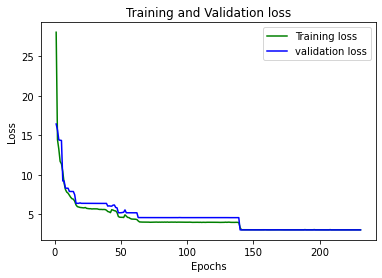

In [47]:
epochs = range(1, len(losses)+1)
plt.plot(epochs, losses, 'g', label='Training loss')
plt.plot(epochs, val_losses, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 预测

In [55]:
# 将测试数据组织为 DaTaloader
test_loader = DataLoader(dataset=torch.utils.data.TensorDataset(torch.tensor(df_test.astype(float).to_numpy())), batch_size=BATCH_SIZE)

In [56]:
# 预测
watch_pred = []
share_pred = []
with torch.no_grad():
    # Uses loader to fetch one mini-batch for testing
    for x_test in test_loader:
        # Again, sends data to same device as model
        x_test = x_test[0]
        x_test = x_test.to(device)

        model.eval()
        # Makes predictions
        yhat = model(x_test.float())
        yhat = yhat.squeeze(0)
        yhat = yhat.view(-1, 11)
        
        yhat_watch = yhat[:, :10]
        yhat_share = yhat[:, 10:]

        # save
        watch_pred.append(yhat_watch)
        share_pred.append(yhat_share)
#         break

In [57]:
# 处理结果，还原为真实label
watch_preds = torch.cat(watch_pred, dim=0)
watch_preds = torch.detach(watch_preds).cpu()
watch_preds_label = np.argmax(watch_preds,axis=1)

In [58]:
print(watch_preds)
print(watch_preds_label.shape)

tensor([[0.0685, 0.2736, 0.1459,  ..., 0.0522, 0.0521, 0.1010],
        [0.1576, 0.1698, 0.0956,  ..., 0.0520, 0.0623, 0.1920],
        [0.0328, 0.1698, 0.1322,  ..., 0.0567, 0.0732, 0.2122],
        ...,
        [0.0239, 0.1754, 0.1261,  ..., 0.0567, 0.0694, 0.1513],
        [0.0397, 0.1846, 0.1349,  ..., 0.0567, 0.0634, 0.1537],
        [0.0411, 0.1924, 0.1180,  ..., 0.0567, 0.0705, 0.2255]])
torch.Size([2822180])


In [59]:
torch.max(watch_preds_label)

tensor(9)

In [71]:
Counter(watch_preds_label.numpy())

Counter({1: 1675084, 9: 885686, 0: 252545, 2: 5958, 8: 2907})

In [656]:
# torch.max(watch_preds_label, dim=0)

torch.return_types.max(
values=tensor(0),
indices=tensor(0))

In [63]:
share_preds = torch.cat(share_pred, dim=0)
share_preds = torch.detach(share_preds).cpu()
share_preds_label = np.rint(share_preds)

In [65]:
print(share_preds_label)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [68]:
torch.max(share_preds)

tensor(0.0029)

### Testing the model

In [ ]:
test_label_tmp = np.column_stack((np.argmax(test_label[0], axis=1), np.argmax(test_label[1], axis=1)))
test_loader = DataLoader(dataset=getTensorDataset(test_data.to_numpy(), test_label_tmp), batch_size=BATCH_SIZE)

In [ ]:
t1_pred = []
t2_pred = []
t1_target = []
t2_target = []

# We tell PyTorch to NOT use autograd...
with torch.no_grad():
    # Uses loader to fetch one mini-batch for testing
    epoch_loss = []
    for x_test, y_test in test_loader:
        # Again, sends data to same device as model
        x_test = x_test.to(device)
        y_test = y_test.to(device)

        model.eval()
        # Makes predictions
        yhat = model(x_test)

        y_test_t1, y_test_t2 = y_test[:, 0], y_test[:, 1]
        yhat_t1, yhat_t2 = yhat[0], yhat[1]

        loss_t1 = loss_fn(yhat_t1, y_test_t1.view(-1, 1))
        loss_t2 = loss_fn(yhat_t2, y_test_t2.view(-1, 1))
        loss = loss_t1 + loss_t2
        
        # predict
        t1_hat = yhat_t1.view(-1) > 0.5
        t2_hat = yhat_t2.view(-1) > 0.5
        
        # save
        t1_pred.append(t1_hat)
        t2_pred.append(t2_hat)
        t1_target.append(y_test_t1)
        t2_target.append(y_test_t2)
        

        epoch_loss.append(loss.item())
print(np.mean(epoch_loss))

0.5134528784119353


In [ ]:
t1_pred = torch.cat(t1_pred)
t2_pred = torch.cat(t2_pred)
t1_target = torch.cat(t1_target)
t2_target = torch.cat(t2_target)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(t1_target.cpu().numpy(), t1_pred.cpu().numpy())

array([[46694,   103],
       [ 2486,   598]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(t1_target.cpu().numpy(), t1_pred.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     46797
         1.0       0.85      0.19      0.32      3084

    accuracy                           0.95     49881
   macro avg       0.90      0.60      0.64     49881
weighted avg       0.94      0.95      0.93     49881



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(t2_target.cpu().numpy(), t2_pred.cpu().numpy()))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90     28284
         1.0       0.86      0.89      0.87     21597

    accuracy                           0.89     49881
   macro avg       0.89      0.89      0.89     49881
weighted avg       0.89      0.89      0.89     49881



### Testing example for the loss function 

In [ ]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([[[0.1, 0.5], [0.1, 0.5]], [[0.1, 0.5], [0.3, 0.5]], [[0.1, 0.5], [1.0, 1.0]]])
target = torch.tensor([[0, 0], [1, 1], [1, 1]])
output = loss(input, target)
output

tensor(0.5821)